W poprzednim zeszycie poznaliśmy metody dla Sieci Bayesowskich, gdzie wszystkie zmienne były dyskretne. Każdy z rozkładów warunkowych był zapisany w formie tabeli z wykorzystaniem klasy `TabularCPD`, która dziedzy po klasie `DiscreteFactor`.

Kolejną klasą dziedziczącą po `DiscreteFactor` jest [`JointProbabilityDistribution`](http://pgmpy.org/factors.html#pgmpy.factors.discrete.JointProbabilityDistribution.JointProbabilityDistribution), która jak sama nazwa wskazuje, służy do reprezentowania łącznych rozkładów prawdopobieństwa dla zmiennych losowych dyskretnych.

In [1]:
from pgmpy.factors.discrete.JointProbabilityDistribution import JointProbabilityDistribution

/usr/local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Funkcja `__init__` przyjmuje 3 argumenty:
- `variables` - lista zmiennych na których określony jest rozkład
- `cardinality` - lista rozmiarów nośnika dla każdej zmiennej
- `values` - lista wartości prawdopobieństwa dla każdego z możliwych stanów wektora losowego

Czyli dla zmiennych $x1$, $x2$ i $x3$ o następującym rozkładzie łącznym:
> 
        +-----+-----+-----+---------------------------------+
        |  x1 |  x2 |  x3 |    P(x1, x2, x2)                |
        +-----+-----+-----+---------------------------------+
        | x1_0| x2_0| x3_0|    P(x1_0, x2_0, x3_0) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        | x1_1| x2_0| x3_0|    P(x1_1, x2_0, x3_0) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        | x1_0| x2_1| x3_0|    P(x1_0, x2_1, x3_0) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        | x1_1| x2_1| x3_0|    P(x1_1, x2_1, x3_0) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        | x1_0| x2_0| x3_1|    P(x1_0, x2_0, x3_1) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        | x1_1| x2_0| x3_1|    P(x1_1, x2_0, x3_1) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        | x1_0| x2_1| x3_1|    P(x1_0, x2_1, x3_1) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        | x1_1| x2_1| x3_1|    P(x1_1, x2_1, x3_1) = 0.1250 |
        +-----+-----+-----+---------------------------------+
        
obiekt rozkładu łącznego zainicjujemy w następujący sposób

In [2]:
import numpy as np

In [3]:
jpd = JointProbabilityDistribution(
    ['x1', 'x2', 'x3'],
    [2, 2, 2],
    np.ones(8)/8,
)

Możemy teraz na przykład sprawdzić niezależnośc warunkową $x1$ od $x2$ pod warunkiem $x3=0$:

In [4]:
jpd.check_independence(event1=['x1'], event2=['x2'], event3=[('x3', 0)])

True

Albo zwykłą niezależność $x1$ od $(x2, x3)$:

In [5]:
jpd.check_independence(event1=['x1'], event2=['x2', 'x3'],)

True

I wiele innych.

# Zmienne ciągłe

Ograniczanie modelowania tylko do zmiennych dyskretnych jest niepraktyczne jednak mimo to większość pakietów open-source nie posiada wsparcia dla ciągłych zmiennych losowych. Na tym tle wyróżnia się pgmpy, które posiada pewne możliwości w tym zakresie.

Klasą pozwalającą na implementację ciągłych rozkładów łącznych jest [pgmpy.factors.continuous.ContinuousFactor.ContinuousFactor](http://pgmpy.org/factors.html#pgmpy.factors.continuous.ContinuousFactor.ContinuousFactor)

Jest to klasa za pomocą której możemy zdefiniować dowolony ciągły rozkład łączny. Funkcja `__init__` przyjmuje następujące argumenty:
   - `variables` - lista nazw zmiennych
   - `pdf` - funkcja gęstości rozkładu łącznego; musi posiadać tyle argumentów, ile zmiennych podaliśmy w `variables`
   
Klasa posiada metody umożliwiające dyskretyzację rozkładu ciągłego, tworzenie rozkładów warunkowych poprzez dzielenie z rozkładami brzegowymi, marginalziację zmiennych i wiele innych operacji potrzebnych we wnioskowaniu.

Wnioskowanie z wykorzystaniem rozkładów z tej klasy staje się obliczeniowo kosztowne dla większych modeli.

In [6]:
import numpy as np
from scipy.special import beta
from scipy.stats import dirichlet

def drichlet_pdf(x, y):
    if x+y==1.0:
        return dirichlet.pdf([x, y], [2, 2])
    else:
        return 0

from pgmpy.factors.continuous import ContinuousFactor
dirichlet_factor = ContinuousFactor(['x', 'y'], drichlet_pdf)

In [7]:
# pdf(0.3,0.7)
dirichlet_factor.pdf(0.3,0.7)

1.2599999999999998

Zmienne ciągłe są w ogólności problematyczne ze względu na odmienność charakteru operacji, które na nich przeprowadzamy. Marginalizacja, warunkowanie, rozkłady łączne, a w konsekwencji Variable Elimination, Belief Propagation oraz inne metody wnioskowania znacznie się komplikują obliczeniowo. Jak zwykle w takich sytuacjach wyjątkiem jest **wielowymiarowy rozkład normalny**, dla którego jesteśmy w stanie wyprowadzić wszystkie operacje w zamkniętej postaci.

W tym miejscu wprowadzamy tzw. **Canonical Form Representation**:
$$\mathcal{C}(\pmb{x}; K, \pmb{h}, g) = \exp \left( - \frac{1}{2} \pmb{x} ^\intercal K \pmb{x} + \pmb{h}^\intercal \pmb{x} + g \right),$$
dla wektora losowego $\pmb{x}$ o rozkładzie $\mathcal{N}(\pmb{\mu}, \Sigma)$, gdzie
$$
\begin{gather}
K = \Sigma ^{-1} \\
\pmb{h} = \Sigma ^{-1} \pmb{\mu} \\ 
g = - \frac{1}{2}\pmb{\mu}^\intercal \Sigma^{-1} \pmb{\mu} - \log \left((2 \pi)^{n/2}|\Sigma|^{1/2}\right)
\end{gather}
$$

Taka parametryzacja umożliwia łatwe wykonywanie operacji potrzebnych przy wnioskowaniu. Dokładne opisy oraz przykłady, jak i omówienie całego zagadnienia stosowania zmiennych ciągłych w Probabilistycznych Modelach Grafowych odsyłam do:
*Probabilistic Graphical Models, Principles and Techniques, Daphne Koller and Nir Friedman, p. 605 Chapter 14. Inference in Hybrid Networks*

## Gaussian Bayesian Networks
Gaussian Bayesian Networks to model, który składa się wyłącznie z ciągłych zmiennych o rozkładzie normalnym, a wszystkie rozkłady warunkowe są liniowo zależne - nazywamy je linear Gaussian model. Można pokazać, że taki model ustanawia rozkład łączny będący wielowymiarowym rozkładem normalnym.

Niech $Y$ będzie ciągłą zmienną losową z ciągłymi rodzicami $X_1, \ldots, X_k$. Mówimy, że $Y$ ma *linear Gaussian model* jeżeli istnieją parametry $\beta_0, \ldots, \beta_k$ i $\sigma^2$ takie, że
$$p(Y|x_1, \ldots, x_k) = \mathcal{N}(Y|\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k, \sigma^2)$$

Dla tej klasy modeli można wyprowadzić Variable Elimination oraz Belief Propagation.

Literatura:
- *Probabilistic Graphical Models, Principles and Techniques, Daphne Koller and Nir Friedman, p. 247 Chapter 7. Gaussian Network Models*
- *Probabilistic Graphical Models, Principles and Techniques, Daphne Koller and Nir Friedman, p. 608 Chapter 14.2 Variable Elimination in Gaussian Networks*

W pakiecie pgmpy możemy budować Gaussian Bayesian Networks wykorzystując klasy:
- do reprezentowania rozkładów - [pgmpy.factors.continuous.LinearGaussianCPD.LinearGaussianCPD](http://pgmpy.org/factors.html#pgmpy.factors.continuous.LinearGaussianCPD.LinearGaussianCPD)

   Jest to klasa, za pomocą której tworzymy linear Gaussian model dla zmiennej $Y$ zależnej od wektora losowego $[X_1, \ldots, X_k]$. Funkcja `__init__` przyjmuje następujące argumenty:
   - `variable` - nazwa zmiennej
   - `evidence_mean` - lista $k+1$ wartości parametrów modelu $\pmb{\beta}$ z wyrazem wolnym na pierwszej pozycji
   - `evidence_variance`- wariancja $Y$, czyli $\sigma^2$
   - `evidence` - lista nazw zmiennych w wektorze losowym $[X_1, \ldots, X_k]$
   - `beta=None` - argument, który nic nie robi 
   
   Istotnym faktem jest, że klasa posiada metodę `fit`, która zwraca estymator ML dla parametrów modelu na podstawie danych zawierających realizacje $[Y, X_1, \ldots, X_k]$.
   
- do zbudowania modelu - `pgmpy.models.LinearGaussianBayesianNetwork.LinearGaussianBayesianNetwork` o interfejsie analogicznym do `BayesianModel`

In [8]:
from scipy.stats import multivariate_normal
import pandas as pd

real_betas = np.array([1, 0.3, -0.4, 0.7])
real_sigma2 = 0.6
parents_means = np.array([1, 5, -6])
parents_cov = np.array([
    [5, 0, 0],
    [0, 2, 0],
    [0, 0, 0.04]
])

def get_cov(beta_coeffs, cov, i):
    return np.sum(cov[i, :] * beta_coeffs)

gbn_generator = multivariate_normal(
    mean=[*parents_means, real_betas[0]+np.sum(real_betas[1:]*parents_means)],
    cov=np.array([
        [*parents_cov[0, :], get_cov(real_betas[1:], parents_cov, 0)],
        [*parents_cov[1, :], get_cov(real_betas[1:], parents_cov, 1)],
        [*parents_cov[2, :], get_cov(real_betas[1:], parents_cov, 2)],
        [
            get_cov(real_betas[1:], parents_cov, 0),
            get_cov(real_betas[1:], parents_cov, 1),
            get_cov(real_betas[1:], parents_cov, 2),
            real_sigma2 + real_betas[1:]@parents_cov@real_betas[1:].transpose()
            
        ]
    ])
)

df = pd.DataFrame(
    gbn_generator.rvs(size=5000),
    columns=['x1', 'x2', 'x3', '(Y|X)']
)
df.head()

,x1,x2,x3,(Y|X)
0,-0.680643,6.428118,-6.223200,-5.713339
1,0.878862,3.256809,-6.031647,-4.668362
2,-1.708549,5.907494,-6.008416,-5.259146
3,2.887771,3.678213,-5.936534,-4.028137
4,3.033373,7.900034,-6.402537,-5.113182


In [9]:
from pgmpy.models import BayesianModel, LinearGaussianBayesianNetwork
from pgmpy.factors.continuous import LinearGaussianCPD

gnb = LinearGaussianBayesianNetwork([
    ('x1', 'y'),
    ('x2', 'y'),
    ('x3', 'y')
])

betas, sigma = LinearGaussianCPD(
        variable='y',
        evidence_mean=None,
        evidence_variance=None,
        evidence=['x1', 'x2', 'x3']
).fit(data=df, states=['x1', 'x2', 'x3', '(Y|X)'], estimator='MLE')

print(betas)
print(sigma**2)

gnb.add_cpds(
    LinearGaussianCPD(
        variable='x1',
        evidence_mean=[parents_means[0]],
        evidence_variance=parents_cov[0,0],
    ),
    LinearGaussianCPD(
        variable='x2',
        evidence_mean=[parents_means[1]],
        evidence_variance=parents_cov[1,1],
    ),
    LinearGaussianCPD(
        variable='x3',
        evidence_mean=[parents_means[2]],
        evidence_variance=parents_cov[2,2],
    ),
    LinearGaussianCPD(
        variable='y',
        evidence_mean=betas,
        evidence_variance=sigma,
        evidence=['x1', 'x2', 'x3']
    )
)

[ 0.39386563  0.30315608 -0.39966666  0.60104302]
0.6025074684082865


In [10]:
from pgmpy.inference import VariableElimination

Niestety wnioskowanie dla ciągłych modeli nie jest jeszcze gotowe. Ale prawdopodobnie:
    
- łatwo naprawić
- ktoś już to zrobił - biblioteka ma obecnie 567 forków na [github.com/pgmpy/pgmpy](https://github.com/pgmpy/pgmpy)

In [11]:
ve = VariableElimination(gnb)

AttributeError: 'LinearGaussianCPD' object has no attribute 'no_to_name'

# Dyskretyzacja ciągłych rozkładów
Alternatywą dla reprezentacji ciągłych zmiennych jest ich dyskretyzacja. To rozwiązanie nie sprawdzi się w każdej sytuacji, ale umożliwia pracę z (aproksymacjami) dowolnymi rozkładami ciągłymi w Sieciach Bayesowskich.

Przykład zastosowania dyskretyzacji znajduje się w zeszycie **A Bayesian Network to model the influence of energy consumption on greenhouse gases in Italy**.

Dyskretyzację można wykonać "manualnie" albo wykorzystując funkcjonalność biblioteki pgmpy. Klasą bazową dla dyskretyzatorów jest [pgmpy.factors.continuous.discretize.BaseDiscretizer](http://pgmpy.org/factors.html#pgmpy.factors.continuous.discretize.BaseDiscretizer). Obecnie dostępne są dwa algorytmy:
- [RoundingDiscretizer](http://pgmpy.org/factors.html#pgmpy.factors.continuous.discretize.RoundingDiscretizer)
- [UnbiasedDiscretizer](http://pgmpy.org/factors.html#pgmpy.factors.continuous.discretize.UnbiasedDiscretizer)

In [12]:
from pgmpy.factors.continuous.discretize import RoundingDiscretizer, UnbiasedDiscretizer

In [13]:
from scipy.stats import multivariate_t

def multi_t_pdf(x, y):
    return multivariate_t([1.0, -0.5], [[2.1, 0.3], [0.3, 1.5]], df=2).pdf([x, y])

t_factor = ContinuousFactor(['x', 'y'], multi_t_pdf)

In [14]:
t_factor.pdf(1.4, 0)

0.07446062218656523

In [15]:
y_t_factor = t_factor.marginalize(['x'], inplace=False)

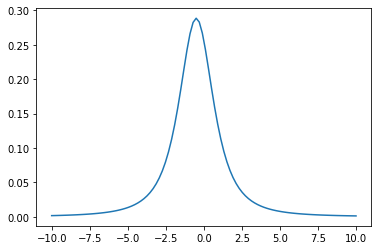

In [16]:
from matplotlib import pyplot as plt
plt.plot(
    np.linspace(-10, 10, num=100),
    list(map(y_t_factor.pdf, np.linspace(-10, 10, num=100).tolist()))
)

In [17]:
y_t_factor.discretize(
    RoundingDiscretizer,
    low=-10,
    high=10,
    cardinality=3,
    cdf_opts={ # default opts
        'epsabs': 1.49e-05,
        'epsrel': 1.49e-05,
        'limit': 30,
    }
)

/usr/local/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


{'y=-10.0': 0.010518690329616961,
 'y=0.0': 0.6200477452616929,
 'y=10.0': 0.010118638479234554}

In [18]:
y_t_factor.discretize(
    UnbiasedDiscretizer,
    low=-10,
    high=10,
    cardinality=3,
    cdf_opts={ # non-default opts
        'epsabs': 1.49e-03,
        'epsrel': 1.49e-03,
        'limit': 15,
    }
)

{'y=-10.0': 0.09919849090002852,
 'y=0.0': 0.8346176678136807,
 'y=10.0': 0.051408546028899216}

In [19]:
# default opts
print('cdf(-10)', y_t_factor.cdf(-10))
print('cdf(0)', y_t_factor.cdf(0))
print('cdf(10)', y_t_factor.cdf(10))

cdf(-10) 0.008108561845438964
cdf(0) 0.6386749974367487
cdf(10) 0.9933333307026779


Analogiczną procedurę można wykonać dla zmiennej `"x"` i utworzyć dyskretny rozkład łączny za pomocą `JointProbabilityDistribution`.